In [2]:
import data_generation as gen

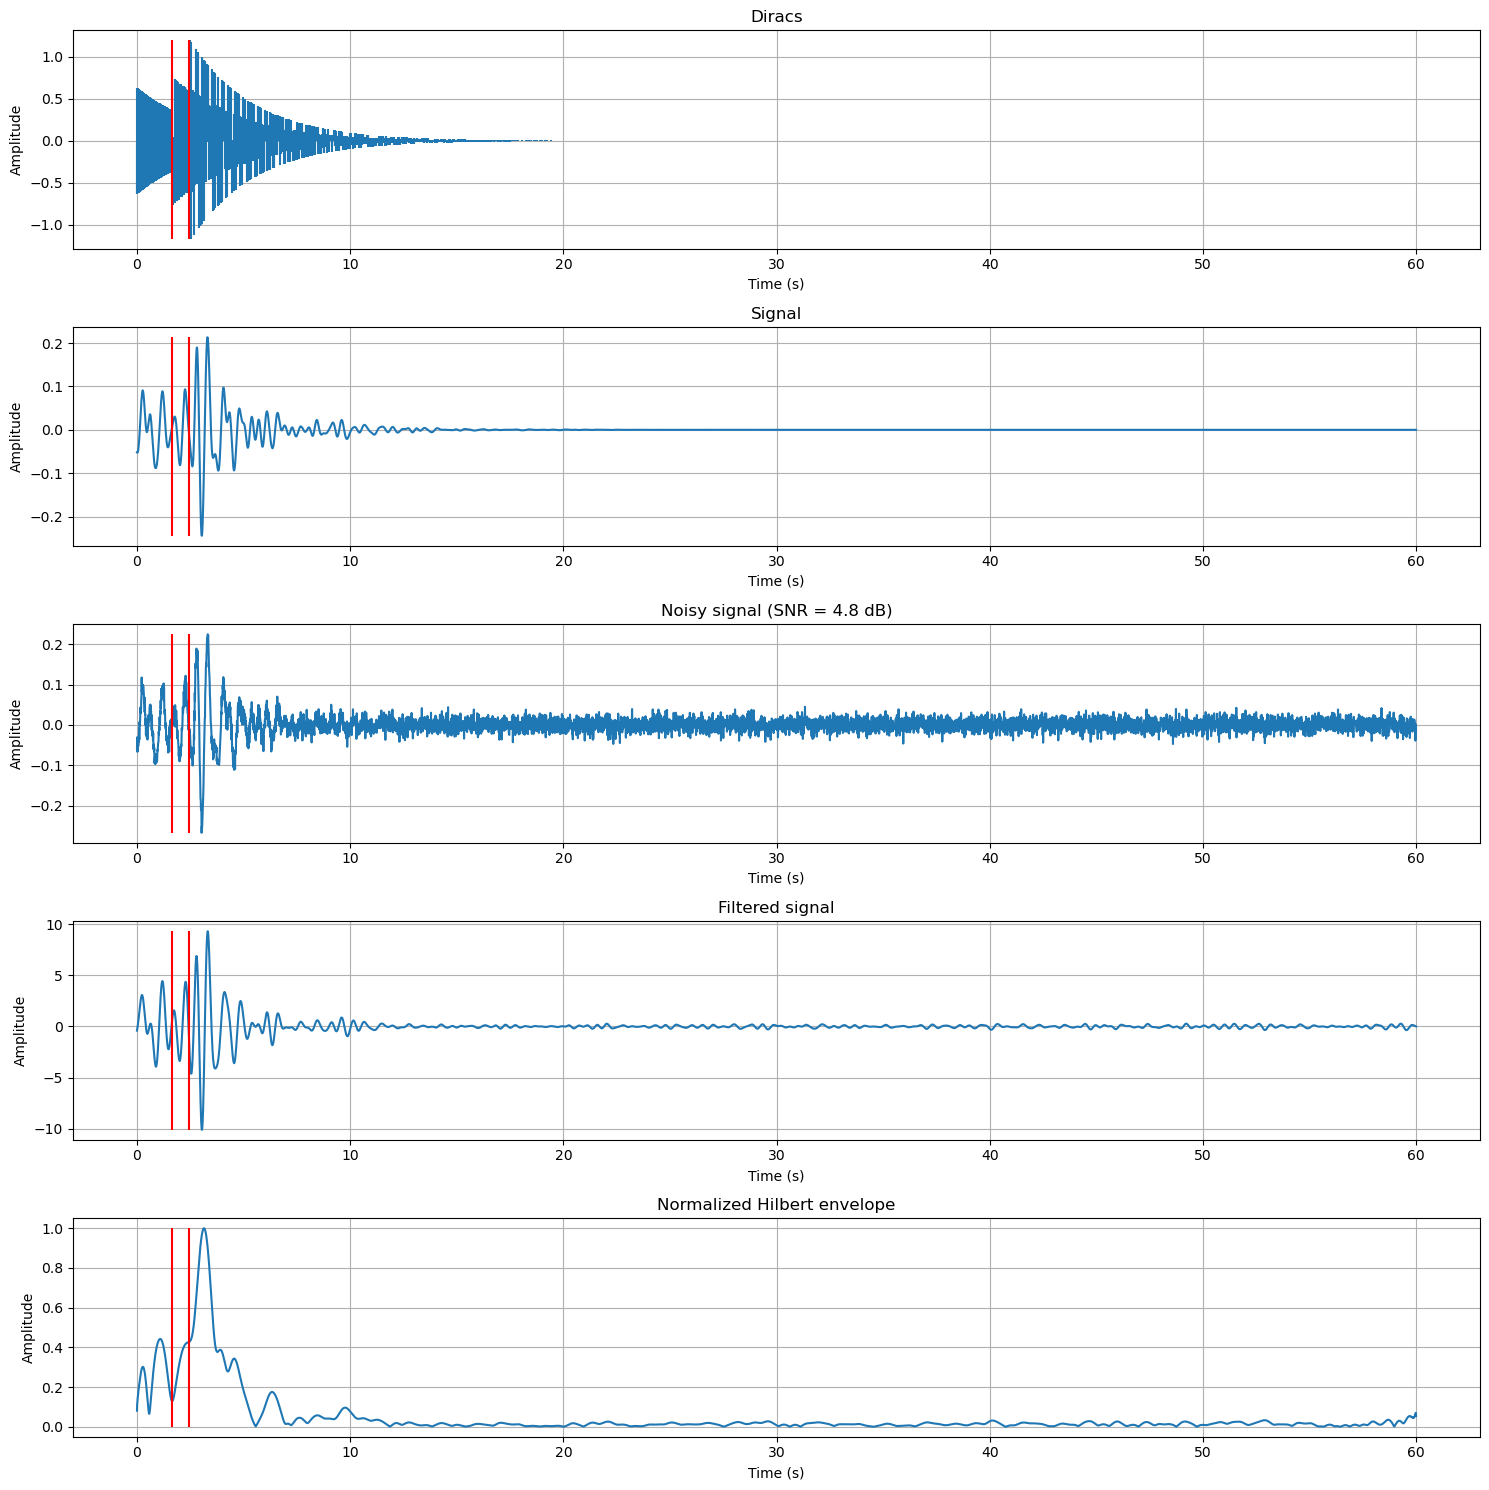

In [6]:
signal, source, stations = gen.signal.generate_one_signal(plot=True)

#### TauP comparison

In [10]:
# Source characteristics
source_lat = source[0]
source_lon = source[1]
source_depth = source[2]
print(f'Depth : {source_depth/1e3:.3f} km')

# Station position
station_lat = stations[0][0]
station_lon = stations[0][1]

Depth : 9.147 km


In [12]:
# My solution
P, pP, sP = gen.arrival_time.travel_times(source_lat, source_lon, source_depth, station_lat, station_lon)
tpP = pP - P
tsP = sP - P

# Results
print(f'P-pP: {tpP:.3f}s - P-sP: {tsP:.3f}s')

P-pP: 1.622s - P-sP: 2.459s


In [14]:
# TauP solution
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees

# Kenett model AK135
model = TauPyModel(model="ak135")

distance_deg = locations2degrees(lat1=source_lat, long1=source_lon,
                                  lat2=station_lat, long2=station_lon)

arrivals = model.get_travel_times(source_depth_in_km=source_depth/1e3,
                                  distance_in_degree=distance_deg,
                                  phase_list=["P", "pP", "sP"])

# Results
tpP = arrivals[1].time - arrivals[0].time
tsP = arrivals[2].time - arrivals[0].time

print(f'P-pP: {tpP:.3f}s - P-sP: {tsP:.3f}s')

P-pP: 2.893s - P-sP: 4.014s


## CNN-DNN model

In [ ]:
# Initiate model
X_tensor, y_tensor, dataset, dataloader, model, criterion, optimizer = gen.crash_model.initiate_model()

In [ ]:
# Train model
gen.crash_model.train_model(model, dataloader, criterion, optimizer, epochs=20)

In [ ]:
# Test model
gen.crash_model.test_model(model)